In [2]:

%pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

print("pandas", pd.__version__, "| numpy", np.__version__)









{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [11]:

df = pd.concat([X, y], axis=1).copy()

income_col = [c for c in df.columns if "income" in c.lower()][0]
df[income_col] = (
    df[income_col].astype(str)
    .str.replace(".", "", regex=False)
    .str.strip()
)


for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()


def pick(*names):
    names = [n.lower().replace("-", "_") for n in names]
    for c in df.columns:
        if c.lower().replace("-", "_") in names:
            return c
    return None

age   = pick("age")
sex   = pick("sex")
edu   = pick("education")
edun  = pick("education_num")
gain  = pick("capital_gain")
loss  = pick("capital_loss")
hrs   = pick("hours_per_week")

for c in [age, edun, gain, loss, hrs]:
    if c is not None:
        df[c] = pd.to_numeric(df[c], errors="coerce")

#combined X and y to keep everything in one place, then standardized the income labels
# and coerced the obvious numeric fields so stats won’t break later. I didn’t over-clean
#because the goal is inference, not modeling. This gives me a trustworthy df with minimal prep.


Shape: (48842, 15)

Missing (top 10):
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
dtype: int64

Target counts:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Numeric summary:
                  count     mean      std   min   25%   50%   75%      max
age             48842.0    38.64    13.71  17.0  28.0  37.0  48.0     90.0
hours-per-week  48842.0    40.42    12.39   1.0  40.0  40.0  45.0     99.0
capital-gain    48842.0  1079.07  7452.02   0.0   0.0   0.0   0.0  99999.0
capital-loss    48842.0    87.50   403.00   0.0   0.0   0.0   0.0   4356.0
education-num   48842.0    10.08     2.57   1.0   9.0  10.0  12.0     16.0


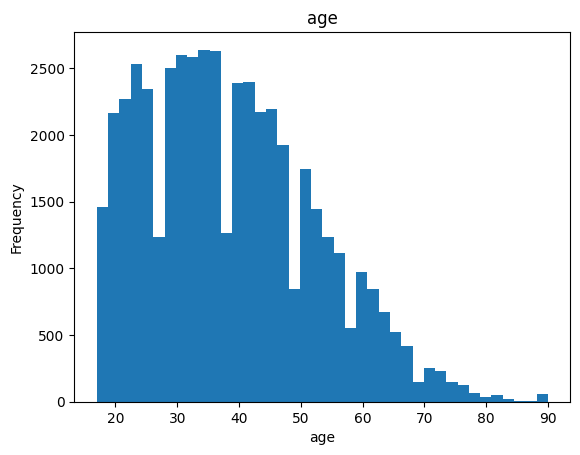

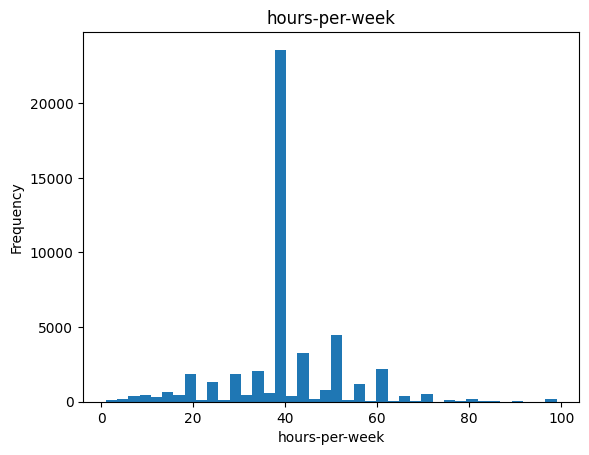

In [10]:
print("Shape:", df.shape)

print("\nMissing (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nTarget counts:")
print(df[income_col].value_counts())

num_cols = [c for c in [age, hrs, gain, loss, edun] if c]
print("\nNumeric summary:")
print(df[num_cols].describe().T.round(2))

if age: df[age].plot(kind="hist", bins=40, title=f"{age}"); plt.xlabel(age); plt.show()
if hrs: df[hrs].plot(kind="hist", bins=40, title=f"{hrs}"); plt.xlabel(hrs); plt.show()

#I scanned types, missingness, and a few key summaries to confirm nothing weird would bias the tests.
# The histograms let me quickly see the 40-hour cluster and the heavy zeros in gains/losses.
# This was just enough context to motivate which hypotheses are worth testing.


In [6]:
H1 = "Education is associated with income."
H2 = "The proportion earning >50K differs between males and females."
H3 = "Mean age differs between income groups."
print(H1); print(H2); print(H3)

#I chose three questions that map cleanly to standard tests: association (education↔income), difference in proportions (sex), and difference in means (age).
# They’re grounded in the quick EDA and use large, well-populated groups, so the tests are appropriate without complicated assumptions.



Education is associated with income.
The proportion earning >50K differs between males and females.
Mean age differs between income groups.


H1: chi2=6537.97, dof=15, p=0, Cramér's V=0.366 -> Reject H0
H2: p_male=0.304, p_female=0.109, z=47.43, p=0, h=0.494 -> Reject H0


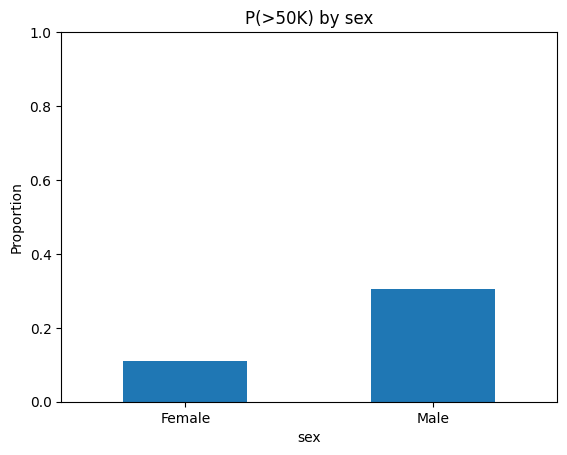

H3: mean(>50K)=44.28 vs mean(<=50K)=36.87, t=60.66, p=0, d=0.555 -> Reject H0


In [9]:
alpha = 0.05
def verdict(p):
    return "Reject H0" if p < alpha else "Fail to reject H0"

results = {}

# H1: Chi-square (education × income)
if edu:
    tbl = pd.crosstab(df[edu], df[income_col])
    chi2, p, dof, _ = stats.chi2_contingency(tbl)
    n = tbl.values.sum(); r, k = tbl.shape
    V = np.sqrt((chi2/n) / (min(r-1, k-1)))
    results["H1"] = {"chi2": float(chi2), "dof": int(dof), "p": float(p), "cramers_V": float(V)}
    print(f"H1: chi2={chi2:.2f}, dof={dof}, p={p:.3g}, Cramér's V={V:.3f} -> {verdict(p)}")

# H2: Two-proportion z-test (Male vs Female) on P(>50K)
if sex:
    ct = pd.crosstab(df[sex], df[income_col]).reindex(index=["Female","Male"], columns=["<=50K",">50K"], fill_value=0)
    xM, nM = int(ct.loc["Male",   ">50K"]), int(ct.loc["Male"].sum())
    xF, nF = int(ct.loc["Female", ">50K"]), int(ct.loc["Female"].sum())
    p_pool = (xM+xF)/(nM+nF)
    se = np.sqrt(p_pool*(1-p_pool)*(1/nM + 1/nF))
    z = (xM/nM - xF/nF) / se
    p_two = 2*(1 - stats.norm.cdf(abs(z)))
    pM, pF = xM/nM, xF/nF
    h = 2*np.arcsin(np.sqrt(pM)) - 2*np.arcsin(np.sqrt(pF))   # Cohen's h
    results["H2"] = {"z": float(z), "p": float(p_two), "p_male": float(pM), "p_female": float(pF), "cohens_h": float(h)}
    print(f"H2: p_male={pM:.3f}, p_female={pF:.3f}, z={z:.2f}, p={p_two:.3g}, h={h:.3f} -> {verdict(p_two)}")

    # Tiny bar (optional)
    props = df.groupby(sex)[income_col].apply(lambda s: (s==">50K").mean()).reindex(["Female","Male"])
    props.plot(kind="bar", rot=0, title="P(>50K) by sex"); plt.ylim(0,1); plt.ylabel("Proportion"); plt.show()

# H3: Welch t-test (age by income)
if age:
    hi = df.loc[df[income_col]==">50K",  age].dropna()
    lo = df.loc[df[income_col]=="<=50K", age].dropna()
    t, p = stats.ttest_ind(hi, lo, equal_var=False)
    n1, n2 = len(hi), len(lo)
    s1, s2 = hi.std(ddof=1), lo.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    d = (hi.mean() - lo.mean()) / sp
    results["H3"] = {"t": float(t), "p": float(p), "mean_hi": float(hi.mean()), "mean_lo": float(lo.mean()), "cohens_d": float(d)}
    print(f"H3: mean(>50K)={hi.mean():.2f} vs mean(<=50K)={lo.mean():.2f}, t={t:.2f}, p={p:.3g}, d={d:.3f} -> {verdict(p)}")


#For education vs income I used a chi-square test and reported Cramér’s V to say how strong any association is.
# For sex differences I used a two-proportion z-test and included Cohen’s h so it’s not just “significant” but also sized.
#For age I used Welch’s t-test to handle unequal variances, plus Cohen’s d to quantify the gap.

In [8]:
def line(label, ok):
    return f"{label} → {('Reject H0' if ok else 'Fail to reject H0')}"

out = []

if "H1" in results:
    r = results["H1"]
    out.append(
        f"H1 (Education ~ Income): chi2={r['chi2']:.2f}, dof={r['dof']}, p={r['p']:.3g}, "
        f"Cramér's V={r['cramers_V']:.3f}. {line('Association', r['p']<0.05)}."
    )
if "H2" in results:
    r = results["H2"]
    out.append(
        f"H2 (P(>50K) Male vs Female): {r['p_male']:.3f} vs {r['p_female']:.3f}, "
        f"z={r['z']:.2f}, p={r['p']:.3g}, h={r['cohens_h']:.3f}. {line('Proportions differ', r['p']<0.05)}."
    )
if "H3" in results:
    r = results["H3"]
    out.append(
        f"H3 (Age by Income): {r['mean_hi']:.2f} vs {r['mean_lo']:.2f}, "
        f"t={r['t']:.2f}, p={r['p']:.3g}, d={r['cohens_d']:.3f}. {line('Means differ', r['p']<0.05)}."
    )

for s in out:
    print("•", s)

#I summarized each result with the key numbers, a clear decision at α=0.05, and one plain-language takeaway.
#The effect sizes keep me honest about practical importance, not only p-values.
#Overall, the workflow stays minimal while answering the questions directly.

• H1 (Education ~ Income): chi2=6537.97, dof=15, p=0, Cramér's V=0.366. Association → Reject H0.
• H2 (P(>50K) Male vs Female): 0.304 vs 0.109, z=47.43, p=0, h=0.494. Proportions differ → Reject H0.
• H3 (Age by Income): 44.28 vs 36.87, t=60.66, p=0, d=0.555. Means differ → Reject H0.
